<img src="img/mvp_art.png" width=200 height=200 />

# CMSC320 Final Project Prototype
## Predicting the Most Valuable Player
---

In [30]:
# Enter into terminal to update website: jupyter nbconvert --to html index.ipynb
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import selenium.webdriver as webdriver
sns.set(style="darkgrid")
%matplotlib inline
mvp = {'Allen Iverson': 'i/iversal01', 'Tim Duncan': 'd/duncati01', 'Kevin Garnett': 'g/garneke01',
      'Steve Nash': 'n/nashst01', 'Dirk Nowitzki': 'n/nowitdi01', 'Kobe Bryant': 'b/bryanko01', 
       'LeBron James': 'j/jamesle01', 'Derrick Rose': 'r/rosede01', 'Kevin Durant': 'd/duranke01',
      'Stephen Curry': 'c/curryst01', 'Russell Westbrook': 'w/westbru01', 'James Harden': 'h/hardeja01',
      'Giannis Antetokounmpo': 'a/antetgi01'}
mvp_years = {'Allen Iverson': ['2000'], 'Tim Duncan': ['2001','2002'], 'Kevin Garnett': ['2003'], 
             'Steve Nash': ['2004', '2005'], 'Dirk Nowitzki': ['2006'], 'Kobe Bryant': ['2007'],
            'LeBron James': ['2008', '2009', '2011', '2012'], 'Derrick Rose': ['2010'], 'Kevin Durant': ['2013'],
            'Stephen Curry': ['2014', '2015'], 'Russell Westbrook': ['2016'], 'James Harden': ['2017'],
            'Giannis Antetokounmpo': ['2018']}
mvp_list = ['Allen Iverson', 'Tim Duncan', 'Tim Duncan', 'Kevin Garnett', 'Steve Nash', 'Steve Nash', 
            'Dirk Nowitzki', 'Kobe Bryant', 'LeBron James', 'LeBron James', 'Derrick Rose', 'LeBron James', 
            'LeBron James', 'Kevin Durant', 'Stephen Curry', 'Stephen Curry', 'Russell Westbrook', 'James Harden',
            'Giannis Antetokounmpo']
mvp_dict = {'Allen Iverson': [('PHI', '2000')], 'Tim Duncan': [('SAS', '2001'), ('SAS', '2002')], 
            'Kevin Garnett': [('MIN', '2003')], 'Steve Nash': [('PHO', '2004'), ('PHO', '2005')],
           'Dirk Nowitzki': [('DAL', '2006')], 'Kobe Bryant': [('LAL', '2007')], 
            'LeBron James': [('CLE', '2008'), ('CLE', '2009'), ('MIA', '2011'), ('MIA', '2012')],
           'Derrick Rose': [('CHI', '2010')], 'Kevin Durant': [('OKC', '2013')], 
            'Stephen Curry': [('GSW', '2014'), ('GSW', '2015')], 'Russell Westbrook': [('OKC', '2016')],
           'James Harden': [('HOU', '2017')], 'Giannis Antetokounmpo': [('MIL', '2018')]}

## MVP Stats
___

## MVP Statistics Database Builder
    i = 0
    for n in mvp:
        m = mvp[n]
        if not (os.path.isfile('MVP/' + m + '/' + 'Table' + '_1.csv')):
            @contextlib2.contextmanager
            def quitting(thing):
                yield thing
                thing.quit()

            with quitting(webdriver.Firefox()) as driver:
                link = 'https://www.basketball-reference.com/players/' + m + '.html' 
                driver.get(link)
                content = driver.page_source
                with open('/tmp/out.html', 'wb') as f:
                    f.write(content.encode('utf-8'))
                data = pd.read_html(content)

            # Split Retired players and unretired(or just retired) players because there is an extra table on current
            # player pages
            if (m in ['i/iversal01', 'd/duncati01', 'g/garneke01', 'n/nashst01', 'b/bryanko']):
                j = 1
                for d in data[8:13]:
                    d.to_csv('MVP/' + m + '/' + 'Table' + '_' + str(j) + '.csv')
                    j += 1
            else:
                j = 1
                for d in data[9:14]:
                    d.to_csv('MVP/' + m + '/' + 'Table' + '_' + str(j) + '.csv')
                    j += 1

        onoff = pd.read_html('https://www.basketball-reference.com/players/' + m + '/on-off/' + str(i+2001))[0]
        team = onoff['Team'].copy(deep=True)
        team['Split'] = {'On Court', 'Off Court', 'On-Off'}
        team.set_index('Split',inplace=True)
        team.to_csv('MVP/' + m + '/' + str(i+2000) + '_' + 'OnOff[Team]' + '.csv')
        opp = onoff['Opponent'].copy(deep=True)
        opp['Split'] = {'On Court', 'Off Court', 'On-Off'}
        opp.set_index('Split',inplace=True)
        opp.to_csv('MVP/' + m + '/' + str(i+2000) + '_' + 'OnOff[Opp]' + '.csv')
        diff = onoff['Opponent'].copy(deep=True)
        diff['Split'] = {'On Court', 'Off Court', 'On-Off'}
        diff.set_index('Split',inplace=True)
        diff.to_csv('MVP/' + m + '/' + str(i+2000) + '_' + 'OnOff[Diff]' + '.csv')
        i += 1

In [33]:
per_game = {}
totals = {}
per_36 = {}
per_100 = {}
advanced = {}
team_onoff = {}
opp_onoff = {}
diff_onoff = {}
for n in mvp:
    m = mvp[n]
    per_game[n] = pd.read_csv('MVP/' + m + '/' + 'Table' + '_1.csv')
    per_game[n].replace('Did Not Play\xa0(injury—ACL)',np.nan,inplace=True)
    per_game[n].dropna(inplace=True)
    per_game[n]['Season'] = [int(str(x).split('-')[0]) for x in per_game[n]['Season']]
    per_game[n]['Age'] = per_game[n]['Age'].astype(int)
    per_game[n]['G'] = per_game[n]['G'].astype(int)
    per_game[n]['GS'] = per_game[n]['GS'].astype(int)
    per_game[n] = per_game[n][per_game[n]['Season'].isin(mvp_years[n])]
    per_game[n].reset_index(inplace=True,drop=True)
    per_game[n].drop(columns=['Unnamed: 0'],inplace=True)
    per_game[n] = per_game[n].loc[:, ['Season', 'Tm', 'Pos', 'G', 'MP', 'PTS', 'TRB', 'AST', 'STL', 'BLK', 'TOV',
                                      'FG%', '3P%', 'eFG%', 'FT%']]
    
    totals[n] = pd.read_csv('MVP/' + m + '/' + 'Table' + '_2.csv')
    totals[n].replace('Did Not Play\xa0(injury—ACL)',np.nan,inplace=True)
    totals[n].dropna(inplace=True)
    totals[n]['Season'] = [int(str(x).split('-')[0]) for x in totals[n]['Season']]
    totals[n]['Age'] = totals[n]['Age'].astype(int)
    totals[n]['G'] = totals[n]['G'].astype(int)
    totals[n]['GS'] = totals[n]['GS'].astype(int)
    totals[n] = totals[n][totals[n]['Season'].isin(mvp_years[n])]
    totals[n].reset_index(inplace=True,drop=True)
    totals[n].drop(columns=['Unnamed: 0'],inplace=True)
    totals[n] = totals[n].loc[:, ['Season', 'Tm', 'Pos', 'G', 'MP', 'PTS', 'TRB', 'AST', 'STL', 'BLK', 'TOV',
                                      'FG%', '3P%', 'eFG%', 'FT%']]

    per_36[n] = pd.read_csv('MVP/' + m + '/' + 'Table' + '_3.csv')
    per_36[n].replace('Did Not Play\xa0(injury—ACL)',np.nan,inplace=True)
    per_36[n].dropna(inplace=True)
    per_36[n]['Season'] = [int(str(x).split('-')[0]) for x in per_36[n]['Season']]
    per_36[n]['Age'] = per_36[n]['Age'].astype(int)
    per_36[n]['G'] = per_36[n]['G'].astype(int)
    per_36[n]['GS'] = per_36[n]['GS'].astype(int)
    per_36[n] = per_36[n][per_36[n]['Season'].isin(mvp_years[n])]
    per_36[n].reset_index(inplace=True,drop=True)
    per_36[n].drop(columns=['Unnamed: 0'],inplace=True)
    per_36[n] = per_36[n].loc[:, ['Season', 'Tm', 'Pos', 'G', 'MP', 'PTS', 'TRB', 'AST', 'STL', 'BLK', 'TOV',
                                      'FG%', '3P%', 'eFG%', 'FT%']]

    per_100[n] = pd.read_csv('MVP/' + m + '/' + 'Table' + '_4.csv')
    per_100[n].replace('Did Not Play\xa0(injury—ACL)',np.nan,inplace=True)
    if 'Unnamed: 29' in per_100[n].columns:
        per_100[n].drop(columns=['Unnamed: 29'],inplace=True)
    per_100[n].dropna(inplace=True)
    per_100[n]['Season'] = [int(str(x).split('-')[0]) for x in per_100[n]['Season']]
    per_100[n]['Age'] = per_100[n]['Age'].astype(int)
    per_100[n]['G'] = per_100[n]['G'].astype(int)
    per_100[n]['GS'] = per_100[n]['GS'].astype(int)
    per_100[n] = per_100[n][per_100[n]['Season'].isin(mvp_years[n])]
    per_100[n].reset_index(inplace=True,drop=True)
    per_100[n].drop(columns=['Unnamed: 0'],inplace=True)
    per_100[n] = per_100[n].loc[:, ['Season', 'Tm', 'Pos', 'G', 'MP', 'PTS', 'TRB', 'AST', 'STL', 'BLK', 'TOV',
                                      'FG%', '3P%', 'FT%']]
    
    advanced[n] = pd.read_csv('MVP/' + m + '/' + 'Table' + '_5.csv')
    if 'Unnamed: 19' in advanced[n].columns:
        advanced[n].drop(columns=['Unnamed: 19', 'Unnamed: 24'],inplace=True)
    advanced[n].replace('Did Not Play\xa0(injury—ACL)',np.nan,inplace=True)
    advanced[n].dropna(inplace=True)
    advanced[n]['Season'] = [int(str(x).split('-')[0]) for x in advanced[n]['Season']]
    advanced[n]['Age'] = advanced[n]['Age'].astype(int)
    advanced[n]['G'] = advanced[n]['G'].astype(int)
    advanced[n] = advanced[n][advanced[n]['Season'].isin(mvp_years[n])]
    advanced[n].reset_index(inplace=True,drop=True)
    advanced[n].drop(columns=['Unnamed: 0'],inplace=True)
    advanced[n] = advanced[n].loc[:, ['Season', 'Tm', 'Pos', 'G', 'MP', 'PER', 'TS%', '3PAr', 'FTr', 'TRB%', 
                                      'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 
                                     'OBPM', 'DBPM', 'BPM', 'VORP']]

    team_onoff[n] = {}
    for y in mvp_years[n]:
        team_onoff[n][y] = pd.read_csv('MVP/' + m + '/' + y + '_OnOff[Team].csv')

    opp_onoff[n] = {}
    for y in mvp_years[n]:
        opp_onoff[n][y] = pd.read_csv('MVP/' + m + '/' + y + '_OnOff[Opp].csv')

    diff_onoff[n] = {}
    for y in mvp_years[n]:
        diff_onoff[n][y] = pd.read_csv('MVP/' + m + '/' + y + '_OnOff[Diff].csv')

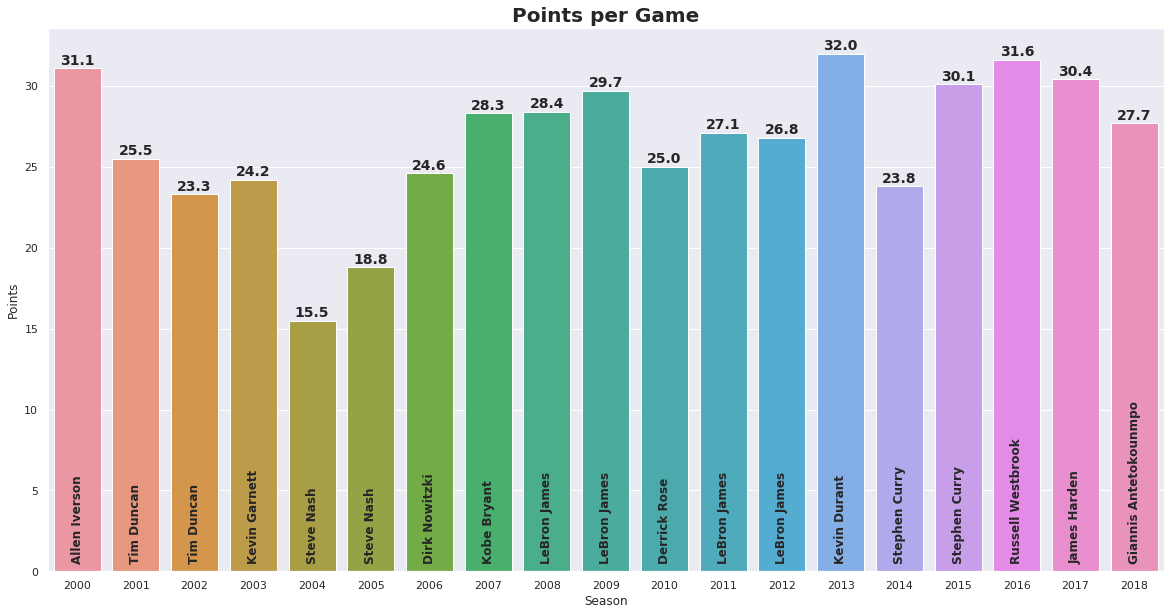

In [86]:
pts = pd.DataFrame(columns=['Player', 'Season', 'PTS'])

for n in mvp:
    for i in range(0,len(per_game[n]['Season'])):
        pts = pts.append({'Player': n, 'Season': per_game[n]['Season'][i], 
                          'PTS': float(per_game[n]['PTS'][i])}, ignore_index=True)

plt.figure(figsize=(20,10))
p = sns.barplot(x='Season',y='PTS',data=pts)
ax = plt.gca()
for i, bar in enumerate(ax.patches):
    h = bar.get_height()
    ax.text(i, h+.5, '{}'.format(h), ha='center', va='center', fontweight='bold', size=14)
i = 0
for i, m in zip(range(0,len(mvp_list)),mvp_list):
    ax.text(i, .5, '{}'.format(m), ha='center', va='bottom', fontweight='bold', size=12, rotation=90)
plt.title('Points per Game', fontweight="bold", fontsize=20)
plt.xlabel('Season')
plt.ylabel('Points')
plt.show()

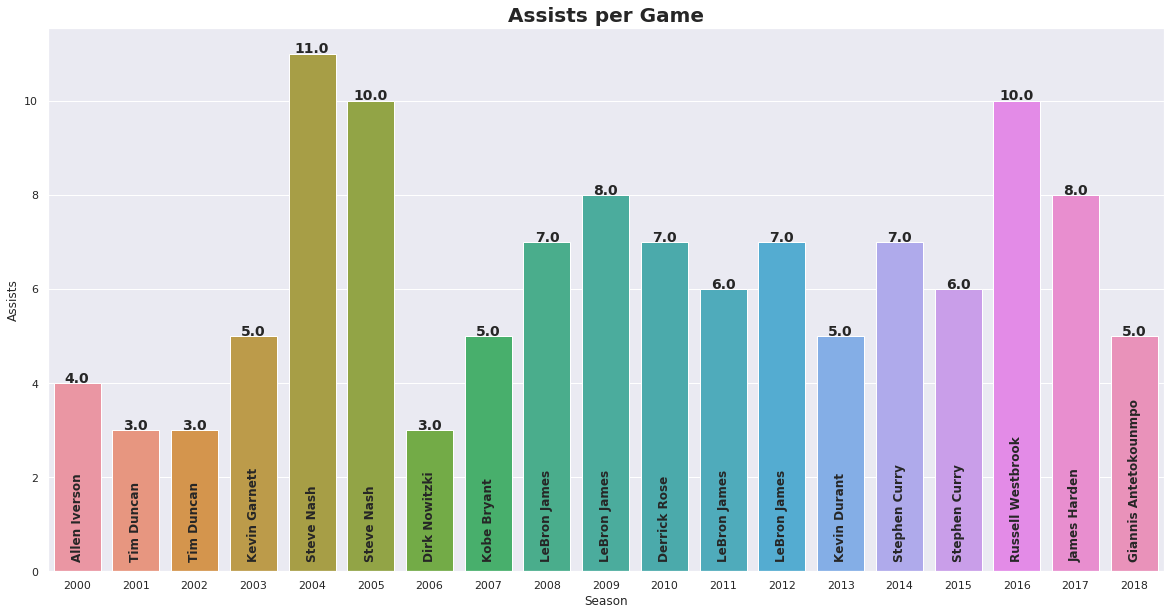

In [88]:
pts = pd.DataFrame(columns=['Player', 'Season', 'AST'])

for n in mvp:
    for i in range(0,len(per_game[n]['Season'])):
        pts = pts.append({'Player': n, 'Season': per_game[n]['Season'][i], 
                          'AST': int(float(per_game[n]['AST'][i]))}, ignore_index=True)

plt.figure(figsize=(20,10))
p = sns.barplot(x='Season',y='AST', data=pts)
ax = plt.gca()
for i, bar in enumerate(ax.patches):
    h = bar.get_height()
    ax.text(i, h+.1, '{}'.format(h), ha='center', va='center', fontweight='bold', size=14)
i = 0
for i, m in zip(range(0,len(mvp_list)),mvp_list):
    ax.text(i, .2, '{}'.format(m), ha='center', va='bottom', fontweight='bold', size=12, rotation=90)
plt.title('Assists per Game', fontweight="bold", fontsize=20)
plt.xlabel('Season')
plt.ylabel('Assists')
plt.show()

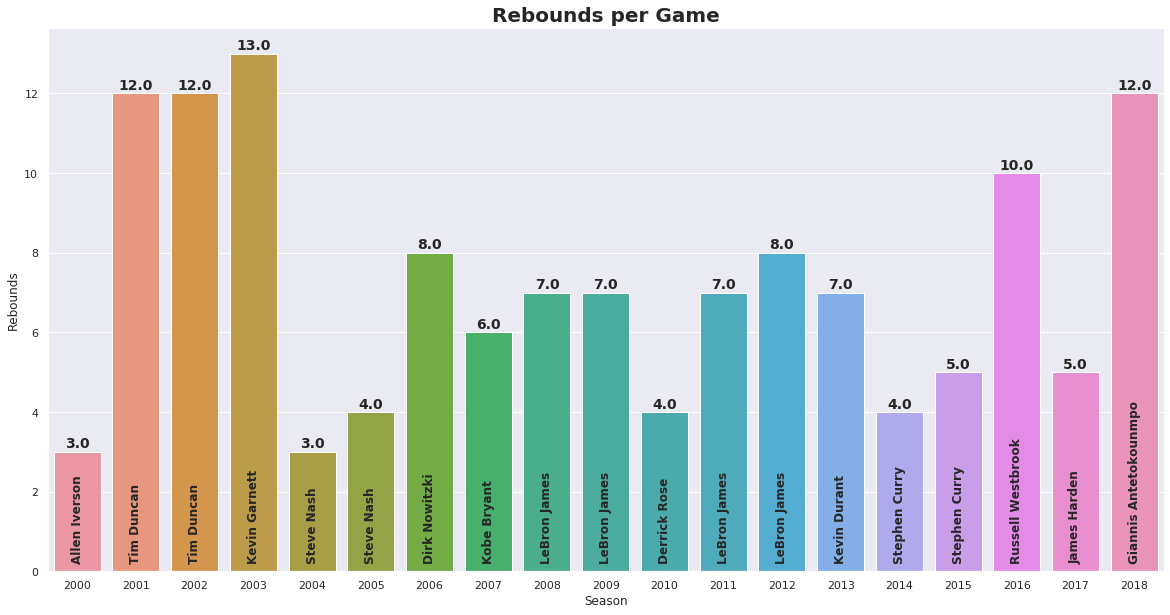

In [87]:
pts = pd.DataFrame(columns=['Player', 'Season', 'TRB'])

for n in mvp:
    for i in range(0,len(per_game[n]['Season'])):
        pts = pts.append({'Player': n, 'Season': per_game[n]['Season'][i], 
                          'TRB': int(float(per_game[n]['TRB'][i]))}, ignore_index=True)

plt.figure(figsize=(20,10))
p = sns.barplot(x='Season',y='TRB', data=pts)
ax = plt.gca()
for i, bar in enumerate(ax.patches):
    h = bar.get_height()
    ax.text(i, h+.2, '{}'.format(h), ha='center', va='center', fontweight='bold', size=14)
i = 0
for i, m in zip(range(0,len(mvp_list)),mvp_list):
    ax.text(i, .2, '{}'.format(m), ha='center', va='bottom', fontweight='bold', size=12, rotation=90)
plt.title('Rebounds per Game', fontweight="bold", fontsize=20)
plt.xlabel('Season')
plt.ylabel('Rebounds')
plt.show()

In [29]:
mvp_teams = {}
for m in mvp_dict:
    mvp_teams[m] = [None]*len(mvp_dict[m])
    for i in range(0,len(mvp_dict[m])):
        team = mvp_dict[m][i][0]
        year = mvp_dict[m][i][1]
        table = pd.read_html('https://www.basketball-reference.com/teams/' + team + 
                             '/stats_per_game_totals.html')[0]
        table['Season'] = [str(x).split('-')[0] for x in table['Season']]
        table = table[table['Season'] == year]
        table['Win_Pct'] = table['W'].astype(int)/table['G'].astype(int)
        table = table.loc[:, ['Season', 'Tm', 'W', 'L', 'Win_Pct', 'PTS', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 
                              'FG%', '3P%', 'FT%']]
        mvp_teams[m][i] = table